# Speech Recognition

***Language classification between French, Spanish and English based on the 'R' sound, using TensorFlow, Scipy, ParselMouth***

# ***CONNEXION DE L'ESPACE DRIVE AU GOOGLE COLAB***

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pour les comptes externes
from google.colab import drive
drive._mount('/content/drive')

# Si l'erreur "ValueError: mount failed: invalid oauth code" s'affiche, il faut monter le Drive avec la partie de code précédente 
# (drive.mount('/content/drive') => sans underscore)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Vérifier que le chemin est bon 
# Après avoir créé un raccourci du répertoire partagé sur mon drive

!ls -l '/content/drive/MyDrive/Projet_CNN/'

total 935
-rw------- 1 root root 952464 Jan 28 11:48 CNN.ipynb
drwx------ 2 root root   4096 Jan 28 11:17 corpus_extraits_audio


# ***ELABORATION DU CORPUS***

## ***Dé-archivage des corpus Mozilla Common Voice***

In [ ]:
# Corpus anglais
!tar -xvzf '/content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-en.tar.gz' -C '/content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-en'

tar (child): /content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-en.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
# Corpus espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-es
!tar -xvzf '/content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-es.tar.gz' -C '/content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-es'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27333504.mp3
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27333506.mp3
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27333568.mp3
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27333570.mp3
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27333571.mp3
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27333572.mp3
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27333573.mp3
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27334052.mp3
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27334053.mp3
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27334055.mp3
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27334056.mp3
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27334057.mp3
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27334211.mp3
cv-corpus-7.0-2021-07-21/es/clips/common_voice_es_27334213.mp3
cv-corpus-7.0-2021-07-21/es/clips/common

In [ ]:
# Corpus français
!mkdir /content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-fr
!tar -xvzf '/content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-fr.tar.gz' -C '/content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-fr'

Streaming output truncated to the last 5000 lines.
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273433.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273439.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273440.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273441.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273442.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273443.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273456.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273459.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273461.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273462.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273463.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273469.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273470.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273471.mp3
cv-corpus-7.0-2021-07-21/fr/clips/common_voice_fr_19273472.mp3
cv-c

## ***Récupérer les audios et le texte associé***
Récupérer les extraits audio (train et test) dont le texte possède la lettre "r": plus de possibilité d'en récupérer le phonème correspondant en langue cible.
(Nous allons vérifier que la présence de la lettre "r" correspond bien aux phonèmes recherchés plus tard avec l'alignement WebMAUS)

In [ ]:
import glob, csv, shutil, os
from random import shuffle

def write_text_file(path_name, text):
  ftext = open(path_name, "w", encoding="utf8")
  ftext.write(text)
  ftext.close()


def corpus_train_test(validate_path, clips_path, corpus_path):
  # Récupération des informations dans les métadonnées
  files_r= []
  with open(validate_path) as f:
    tsv_file = csv.reader(f, delimiter="\t")
    for row in tsv_file:
      client_id = row[0]
      name = row[1]
      text = row[2]
      age = row[5]
      gender = row[6]
      if 'r' in text and age == "twenties" and gender == "male":
        files_r.append((client_id, name, text))
  #print(len(files_r))

  # Randomiser les données pour qu'elles ne soient pas prévisibles 
  # shuffle(files_r)

  # Traitement particulier pour le français : Trier par ordre alphabétique les clients_id des audios sélectionnés
  files_r.sort(key=lambda tup: tup[0]) 

  # Listes des identifiants des locuteurs dans le corpus d'entraînement
  train_client_id = []
  test_client_id = []

  # Remplir des corpus train et test 
  for client_id, name, text in files_r:
    if len(train_client_id) + len(test_client_id) > 1000:    # On ne sélectionne que 800 audios pour le train et 200 audios pour le test
        break
    if os.path.isfile(clips_path + name):
      if len(train_client_id) < 800:   # Extraits pour le corpus train dans cette langue
          train_client_id.append(client_id) 
          shutil.copy(clips_path + name, corpus_path + "train/" + name)
          write_text_file(corpus_path + "train/" + name.split(".")[0] + ".txt", text)
      else :    # Extraits pour le corpus test dans cette langue
        if client_id not in train_client_id:
            test_client_id.append(client_id) 
            shutil.copy(clips_path + name, corpus_path + "test/" + name)
            write_text_file(corpus_path + "test/" + name.split(".")[0] + ".txt", text)
    

In [ ]:
# Corpus anglais 
# !mkdir /content/drive/MyDrive/Projet_CNN/corpus_en/
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_en/train 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_en/test

validate_en = "/content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-en/cv-corpus-7.0-2021-07-21/en/validated.tsv"
clips_en = "/content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-en/cv-corpus-7.0-2021-07-21/en/clips/"
corpus_en = "/content/drive/MyDrive/Projet_CNN/corpus_en/"

corpus_train_test(validate_en, clips_en, corpus_en)

In [ ]:
# Corpus espagnol 
# !mkdir /content/drive/MyDrive/Projet_CNN/corpus_es
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_es/train 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_es/test

validate_es = "/content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-es/cv-corpus-7.0-2021-07-21/es/validated.tsv"
clips_es = "/content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-es/cv-corpus-7.0-2021-07-21/es/clips/"
corpus_es = "/content/drive/MyDrive/Projet_CNN/corpus_es/"

corpus_train_test(validate_es, clips_es, corpus_es)

In [ ]:
# Corpus français 
# Rappel : Pour ce corpus, il y avait environ 1000 locuteurs distincts correspondant à nos critères recherchés
# Donc, par conséquent, nous n'avons pas pu réaliser le traitement de randomisation, car nous ne pouvions avoir autant de données que prévues 
#   sachant que les locuteurs en train ne devaient pas se retrouver dans le test 
# !mkdir /content/drive/MyDrive/Projet_CNN/corpus_fr/
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_fr/train 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_fr/test

validate_fr = "/content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-fr/cv-corpus-7.0-2021-07-21/fr/validated.tsv"
clips_fr = "/content/drive/MyDrive/Projet_CNN/cv-corpus-7.0-2021-07-21-fr/cv-corpus-7.0-2021-07-21/fr/clips/"
corpus_fr = "/content/drive/MyDrive/Projet_CNN/corpus_fr/"

corpus_train_test(validate_fr, clips_fr, corpus_fr)

## ***Sélectionner d'un côté les phonèmes correspondant à des R et de l'autre tous les autres phonèmes***
Les autres phonnèmes nous serviront de données de contrôle. Ainsi, nous pourrons voir si l'analyse des phonèmes R est un caractéristique plus distinctive pour la classification des langues. 

> ### ****Etapes réalisées****
*   Alignement avec WebMaus Basic
*   Lancement du script *cut_signal_and_textgrid_extracts_with_smoothing.praat* dans Praat en changeant les regex recherchées en fonction des symboles Sampa utilisés dans chaque langue


```
# Corpus anglais 
sentence regexTargetIntervals [r]
sentence regexTargetIntervals [^r(<p:>)]

# Corpus espagnol
sentence regexTargetIntervals [(r|rr)]
sentence regexTargetIntervals [^(r|rr|<p:>)]

# Corpus français
sentence regexTargetIntervals [R]
sentence regexTargetIntervals [^(R|?|<p:>)]
```





Les sections d'audios récupérées sont dans les répertoires *corpus_en_cut_audio*, *corpus_es_cut_audio* et *corpus_fr_cut_audio*.

## ***Produire le corpus d'extraits audios***
Sélectionner le nombre approprié d'audios qui servira de base pour les corpus d'images (spectrogrammes et MFCC) utilisés par la suite.

In [ ]:
# Créer tous les répertoires nécessaires 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R   # Corpus de R 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train   # Corpus d'entraînement 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/francais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test    # Corpus de test
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/francais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle    # Corpus de controle (phonèmes aléatoires)
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train   # Corpus d'entraînement 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/francais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test    # Corpus de test
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais

In [ ]:
# Récupérer le nombre approprié d'extraits audios dans chaque langue selon le type de corpus (ratio 80/20 pour train/test)
# Entrainement : 500 exemplaires par langue 
# Test : 125 exemplaires par langue 

import glob
import shutil
from random import shuffle

# Corpus d'entraînement 
def train_audio(path_input_file, path_output):
  list_files = glob.glob(path_input_file)    # Récupérer la liste des fichiers
  shuffle(list_files)     # Fichiers aléatoires
  train_files = list_files[0:500]   # Sélection de 500 exemplaires
  for file in train_files:
    name = file.split("/")[-1]
    shutil.copy(file, path_output + name)   # Déplacer les audios sélectionnés

# Corpus de test
def test_audio(path_input_file, path_output):
  list_files = glob.glob(path_input_file)    # Récupérer la liste des fichiers
  shuffle(list_files)     # Fichiers aléatoires
  test_files = list_files[0:125]   # Sélection de 125 exemplaires
  for file in test_files:
    name = file.split("/")[-1]
    shutil.copy(file, path_output + name)   # Déplacer les audios sélectionnés

In [ ]:
# Corpus anglais 
# -- Corpus de R 
train_audio("/content/drive/MyDrive/Projet_CNN/corpus_en_cut_audio/train_r/*.mp3", "/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/anglais/")
test_audio("/content/drive/MyDrive/Projet_CNN/corpus_en_cut_audio/test_r/*.mp3", "/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/anglais/")
# -- Corpus de phonèmes aléatoires
train_audio("/content/drive/MyDrive/Projet_CNN/corpus_en_cut_audio/train_nonr/*.mp3", "/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/anglais/")
test_audio("/content/drive/MyDrive/Projet_CNN/corpus_en_cut_audio/test_nonr/*.mp3", "/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/anglais/")


# Corpus espagnol 
# -- Corpus de R 
train_audio("/content/drive/MyDrive/Projet_CNN/corpus_es_cut_audio/train_r/*.mp3", "/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/espagnol/")
test_audio("/content/drive/MyDrive/Projet_CNN/corpus_es_cut_audio/test_r/*.mp3", "/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/espagnol/")
# -- Corpus de phonèmes aléatoires
train_audio("/content/drive/MyDrive/Projet_CNN/corpus_es_cut_audio/train_nonr/*.mp3", "/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/espagnol/")
test_audio("/content/drive/MyDrive/Projet_CNN/corpus_es_cut_audio/test_nonr/*.mp3", "/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/espagnol/")


# Corpus français 
# -- Corpus de R 
train_audio("/content/drive/MyDrive/Projet_CNN/corpus_fr_cut_audio/train_r/*.mp3", "/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/francais/")
test_audio("/content/drive/MyDrive/Projet_CNN/corpus_fr_cut_audio/test_r/*.mp3", "/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/francais/")
# -- Corpus de phonèmes aléatoires
train_audio("/content/drive/MyDrive/Projet_CNN/corpus_fr_cut_audio/train_nonr/*.mp3", "/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/francais/")
test_audio("/content/drive/MyDrive/Projet_CNN/corpus_fr_cut_audio/test_nonr/*.mp3", "/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais/")


## ***Récupération de spectogrammes simples, 0 padding***
Création du corpus de spectogrammes

In [ ]:
# Créer tous les répertoires nécessaires 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_R   # Corpus de R 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_R/train   # Corpus d'entraînement 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_R/train/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_R/train/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_R/train/francais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_R/test    # Corpus de test
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_R/test/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_R/test/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_R/test/francais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle    # Corpus de controle (phonèmes aléatoires)
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/train   # Corpus d'entraînement 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/train/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/train/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/train/francais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test    # Corpus de test
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais

Utilisation du script python export_spectrograms_as gray_scale_zero_padding.py pour obtenir les spectogrammes
Instalation du package parselmouth si nécessaire.

In [ ]:
!pip install praat-parselmouth

     |████████████████████████████████| 10.7 MB 3.8 MB/s 


In [ ]:
import librosa
import parselmouth
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import interpolate
from pathlib import Path

# export a 2D numpy array as a greyscale image, with optional zero padding on the right
# argument zero_padding_width_ratio is defined as the ratio of the total image width to be filled with blank pixels
def export_grayscale_image_with_zero_padding(numpy_data, filename, image_width_inches, image_height_inches, resolution_dpi=None, vmin=None, vmax=None, zero_padding_width_ratio=0, value_for_zero_padding=None):
  # add "zeros" (min value in image unless specified as argument value_for_zero_padding) on the right of the image if zero_padding_width_ratio is over 0 and below 1
  if(zero_padding_width_ratio>0 and zero_padding_width_ratio<1):
    if(value_for_zero_padding==None):
      value_for_zero_padding=np.min(numpy_data)
    n_rows = numpy_data.shape[0]
    n_cols = numpy_data.shape[1]
    n_added_cols = int(np.round(n_cols * zero_padding_width_ratio / (1 - zero_padding_width_ratio)))
    added_zeros = np.ones((n_rows, n_added_cols))*value_for_zero_padding
    zero_padded_numpy_data = np.concatenate((numpy_data,added_zeros), axis = 1)
  else:
    zero_padded_numpy_data = numpy_data

  fig = plt.figure(frameon=False)
  fig.set_size_inches(image_width_inches,image_height_inches)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  ax.imshow(zero_padded_numpy_data, aspect="auto", cmap="gray_r", vmin=vmin, vmax=vmax)
  fig.savefig(filename, dpi = resolution_dpi)
  plt.close(fig)

# export Praat spectrogram (Parselmouth spectrogram object) as greyscale image: straightforward version
# optional zero padding on the right: argument zero_padding_width_ratio is defined as the ratio of the total image width to be filled with blank pixels
def export_grayscale_spectrogram_with_zero_padding(spectrogram, filename, image_width_inches, image_height_inches, resolution_dpi=None, dynamic_range=70, zero_padding_width_ratio=0, value_for_zero_padding=None):
  X, Y = spectrogram.x_grid(), spectrogram.y_grid()
  sg_db = 10 * np.log10(spectrogram.values)

  # add "zeros" (min value in image unless specified as argument value_for_zero_padding) on the right of the image if zero_padding_width_ratio is over 0 and below 1
  if(zero_padding_width_ratio>0 and zero_padding_width_ratio<1):
    if(value_for_zero_padding==None):
      value_for_zero_padding=np.min(sg_db)
    n_rows = sg_db.shape[0]
    n_cols = sg_db.shape[1]
    n_added_cols = int(np.round(n_cols * zero_padding_width_ratio / (1 - zero_padding_width_ratio)))
    added_zeros = np.ones((n_rows, n_added_cols))*value_for_zero_padding
    zero_padded_sg_db = np.concatenate((sg_db,added_zeros), axis = 1)
  else:
    zero_padded_sg_db = sg_db

  fig = plt.figure(frameon=False)
  fig.set_size_inches(image_width_inches,image_height_inches)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  ax.imshow(zero_padded_sg_db, aspect="auto", cmap="gray_r", vmin=sg_db.max() - dynamic_range, vmax=None)
  fig.savefig(filename, dpi = resolution_dpi)
  plt.close(fig)

# export Praat spectrogram (Parselmouth spectrogram object) as greyscale image: enhanced version with preemphasis and bivariate splines smoothing, closer to Praat display
def export_smoothed_grayscale_spectrogram_with_zero_padding(spectrogram, filename, image_width_inches, image_height_inches, resolution_dpi=None, dynamic_range=70, preemphasis_dB_by_octave=6, zero_padding_width_ratio=0, value_for_zero_padding=None):
  X, Y = spectrogram.x_grid(), spectrogram.y_grid()
  Xbins, Ybins = spectrogram.x_bins(), spectrogram.y_bins()
  Xmid = np.column_stack((Xbins[:,0],np.diff(Xbins,axis=1)/2)).sum(axis=1)
  Ymid = np.column_stack((Ybins[:,0],np.diff(Ybins,axis=1)/2)).sum(axis=1)
  # if requested, add pre-emphasis to boost higher frequency display (typical value for pre-emphasis = 6dB/octave)
  if(preemphasis_dB_by_octave>0):
    if(Ymid[0]<=0):
      logYmid = np.append(0,np.log2(Ymid[1::]))
    else:
      logYmid = np.log2(Ymid)
    intensityBoost_dB = (logYmid - min(logYmid))*preemphasis_dB_by_octave
    sg_db = (10 * np.log10(spectrogram.values))+intensityBoost_dB[:,np.newaxis]
  else:
    sg_db = 10 * np.log10(spectrogram.values)
  fig = plt.figure(frameon=False)
  fig.set_size_inches(image_width_inches,image_height_inches)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)

  # interpolate values on both time and frequency dimensions using bivariate splines
  # (adapted from https://stackoverflow.com/a/32567022)
  f = interpolate.RectBivariateSpline(Xmid, Ymid, sg_db.T)
  Xnew = np.linspace(X[0], X[-1], 10*len(X))
  Ynew = np.linspace(Y[0], Y[-1], 10*len(Y))
  sg_bd_interp = f(Xnew, Ynew).T

  # add "zeros" (min value in image unless specified as argument value_for_zero_padding) on the right of the image if zero_padding_width_ratio is over 0 and below 1
  if(zero_padding_width_ratio>0 and zero_padding_width_ratio<1):
    if(value_for_zero_padding==None):
      value_for_zero_padding=np.min(sg_bd_interp)
    n_rows = sg_bd_interp.shape[0]
    n_cols = sg_bd_interp.shape[1]
    n_added_cols = int(np.round(n_cols * zero_padding_width_ratio / (1 - zero_padding_width_ratio)))
    added_zeros = np.ones((n_rows, n_added_cols))*value_for_zero_padding
    zero_padded_sg_bd_interp = np.concatenate((sg_bd_interp,added_zeros), axis = 1)
  else:
    zero_padded_sg_bd_interp = sg_bd_interp

  ax.imshow(zero_padded_sg_bd_interp, aspect="auto", cmap="gray_r", vmin=sg_db.max() - dynamic_range, vmax=None)
  fig.savefig(filename, dpi = resolution_dpi)
  plt.close(fig)

# utility function to export parselmouth spectrogam values to file (e.g. for comparison with other computation methods)
def export_spectrogram_values_to_file(spectrogram, filename, convert_to_dB=True):
  if(convert_to_dB):
    values = pd.DataFrame(10 * np.log10(spectrogram.values))
  else:
    values = pd.DataFrame(spectrogram.values)
  values.to_csv(filename, sep = '\t', index = False)

def compute_librosa_spectrogram(sndSignal, sampleRate, windowLengthSeconds=0.005, timeStepSeconds=0.002):
  # convert window length and time step to number of samples
  win_length = int(np.round(windowLengthSeconds*sampleRate))
  hop_length = int(np.round(timeStepSeconds*sampleRate))
  # define n_fft as the next power of 2 after win_length
  n_fft = int(np.power(2,np.ceil(np.log2(win_length))))
  # get amplitude spectrogram
  spectro = np.abs(librosa.stft(sndSignal, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann')) ** 2
  # convert it to dB
  spectro = librosa.power_to_db(spectro, ref=np.max)
  # flip the array vertically to have lowest frequencies on the bottom side
  return(np.flipud(spectro))


In [ ]:
##############################

## definition des parametres
# dossiers contenant les extraits audio à analyser
dossiers_extraits_audio = [ 
                           '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/francais',
                           # '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/espagnol', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/espagnol',
                           # '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/anglais', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/anglais',
                           # '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/francais', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/francais',
                           #'/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/espagnol', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/espagnol',
                           # '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/anglais', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/anglais'
                           ]
duree_max_signal_secondes = 0.12
# export images
dossier_images_principal = "/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes"
extension_images = ".png"
largeur_images_pixels = 50
hauteur_images_pixels = 50

# conversion en pouces de la taille en pixels
resolution_images_dpi = 100
largeur_images_pouces = largeur_images_pixels/resolution_images_dpi
hauteur_images_pouces = hauteur_images_pixels/resolution_images_dpi


##############################

# paramétrage pour les spectrogrammes calculés par Praat via les fonctions de Parselmouth
max_frequency_spectrogram_Hz = 8000


In [ ]:
import glob, os
from random import shuffle

for path in dossiers_extraits_audio:
  cat_corpus= path.split('/')[-3] # le répertoire est celui des phonèmes R ou des phonèmes de contrôles
  type_corpus = path.split('/')[-2] # le répertoire est un train ou un test
  langue = path.split('/')[-1] # la langue des extraits audios
  print(path)
  for f in os.listdir(path):
      snd=parselmouth.Sound(path+'/'+f)
      spectro=snd.to_spectrogram(maximum_frequency=max_frequency_spectrogram_Hz)
      zeroPaddingWidthRatio = (duree_max_signal_secondes-snd.get_total_duration())/duree_max_signal_secondes
      
      dossier_images = dossier_images_principal + '/' + cat_corpus + '/' + type_corpus + '/' + langue
      print(dossier_images + "/" + f + extension_images)
      export_grayscale_spectrogram_with_zero_padding(spectro, dossier_images + "/" + f + extension_images, largeur_images_pouces, hauteur_images_pouces, resolution_images_dpi, zero_padding_width_ratio=zeroPaddingWidthRatio)
      #export_smoothed_grayscale_spectrogram_with_zero_padding(spectro, dossier_images + "/" + f + "_smooth" + extension_images, largeur_images_pouces, hauteur_images_pouces, resolution_images_dpi, preemphasis_dB_by_octave=6, zero_padding_width_ratio=zeroPaddingWidthRatio)
      #export_smoothed_grayscale_spectrogram_with_zero_padding(spectro, dossier_images + "/" + f + "_smooth_noPreemphasis" + extension_images, largeur_images_pouces, hauteur_images_pouces, resolution_images_dpi, preemphasis_dB_by_octave=0, zero_padding_width_ratio=zeroPaddingWidthRatio)


/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais
/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/common_voice_fr_17313576_extrait20_9~.mp3.png
/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/common_voice_fr_17328716_extrait12_e.mp3.png
/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/common_voice_fr_17313708_extrait10_v.mp3.png
/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/common_voice_fr_17313461_extrait7_E.mp3.png
/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/common_voice_fr_17313765_extrait31_a.mp3.png
/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/common_voice_fr_17315755_extrait12_2.mp3.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10


/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/common_voice_fr_17313698_extrait42_k.mp3.png
/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/common_voice_fr_17313604_extrait7_a.mp3.png
/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/common_voice_fr_17315627_extrait5_s.mp3.png
/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/common_voice_fr_17313450_extrait43_t.mp3.png
/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/common_voice_fr_17313417_extrait13_l.mp3.png
/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/common_voice_fr_17313330_extrait8_n.mp3.png
/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/common_voice_fr_17315612_extrait6_k.mp3.png
/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_controle/test/francais/c

## ***Corpus de Spectrogramme***

In [ ]:
!pip install praat-parselmouth

     |████████████████████████████████| 10.7 MB 3.8 MB/s 


In [ ]:
# Créer tous les répertoires nécessaires 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_R   # Corpus de R 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_R/train   # Corpus d'entraînement 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_R/train/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_R/train/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_R/train/francais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_R/test    # Corpus de test
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_R/test/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_R/test/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_R/test/francais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_controle    # Corpus de controle (phonèmes aléatoires)
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_controle/train   # Corpus d'entraînement 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_controle/train/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_controle/train/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_controle/train/francais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_controle/test    # Corpus de test
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_controle/test/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_controle/test/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/corpus_controle/test/francais

In [ ]:
import librosa
import parselmouth
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import interpolate
from pathlib import Path
import glob, os
from random import shuffle


# export a 2D numpy array as a greyscale image
def export_grayscale_image(numpy_data, filename, image_width_inches, image_height_inches, resolution_dpi=None, vmin=None, vmax=None):
  fig = plt.figure(frameon=False)
  fig.set_size_inches(image_width_inches,image_height_inches)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  ax.imshow(numpy_data, aspect="auto", cmap="gray_r", vmin=vmin, vmax=vmax)
  fig.savefig(filename, dpi = resolution_dpi)
  plt.close(fig)

# export Praat spectrogram (Parselmouth spectrogram object) as greyscale image: straightforward version
def export_grayscale_spectrogram(spectrogram, filename, image_width_inches, image_height_inches, resolution_dpi=None, dynamic_range=70):
  X, Y = spectrogram.x_grid(), spectrogram.y_grid()
  sg_db = 10 * np.log10(spectrogram.values)
  fig = plt.figure(frameon=False)
  fig.set_size_inches(image_width_inches,image_height_inches)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='gray_r')
  plt.ylim([spectrogram.ymin, spectrogram.ymax])
  fig.savefig(filename, dpi = resolution_dpi)
  plt.close(fig)

# export Praat spectrogram (Parselmouth spectrogram object) as greyscale image: enhanced version with preemphasis and bivariate splines smoothing, closer to Praat display
def export_smoothed_grayscale_spectrogram(spectrogram, filename, image_width_inches, image_height_inches, resolution_dpi=None, dynamic_range=70, preemphasis_dB_by_octave=6):
  X, Y = spectrogram.x_grid(), spectrogram.y_grid()
  Xbins, Ybins = spectrogram.x_bins(), spectrogram.y_bins()
  Xmid = np.column_stack((Xbins[:,0],np.diff(Xbins,axis=1)/2)).sum(axis=1)
  Ymid = np.column_stack((Ybins[:,0],np.diff(Ybins,axis=1)/2)).sum(axis=1)
  # if requested, add pre-emphasis to boost higher frequency display (typical value for pre-emphasis = 6dB/octave)
  if(preemphasis_dB_by_octave>0):
    if(Ymid[0]<=0):
      logYmid = np.append(0,np.log2(Ymid[1::]))
    else:
      logYmid = np.log2(Ymid)
    intensityBoost_dB = (logYmid - min(logYmid))*preemphasis_dB_by_octave
    sg_db = (10 * np.log10(spectrogram.values))+intensityBoost_dB[:,np.newaxis]
  else:
    sg_db = 10 * np.log10(spectrogram.values)
  fig = plt.figure(frameon=False)
  fig.set_size_inches(image_width_inches,image_height_inches)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)

  # interpolate values on both time and frequency dimensions using bivariate splines
  # (adapted from https://stackoverflow.com/a/32567022)
  f = interpolate.RectBivariateSpline(Xmid, Ymid, sg_db.T)
  Xnew = np.linspace(X[0], X[-1], 10*len(X))
  Ynew = np.linspace(Y[0], Y[-1], 10*len(Y)) # was it wider spaced than freqs on purpose?
  sg_bd_interp = f(Xnew, Ynew).T
  plt.pcolormesh(Xnew, Ynew, sg_bd_interp, vmin=sg_db.max() - dynamic_range, cmap='gray_r', shading='auto')
  plt.ylim([spectrogram.ymin, spectrogram.ymax])
  fig.savefig(filename, dpi = resolution_dpi)
  plt.close(fig)

# utility function to export parselmouth spectrogam values to file (e.g. for comparison with other computation methods)
def export_spectrogram_values_to_file(spectrogram, filename, convert_to_dB=True):
  if(convert_to_dB):
    values = pd.DataFrame(10 * np.log10(spectrogram.values))
  else:
    values = pd.DataFrame(spectrogram.values)
  values.to_csv(filename, sep = '\t', index = False)

def compute_librosa_spectrogram(sndSignal, sampleRate, windowLengthSeconds=0.005, timeStepSeconds=0.002):
  # convert window length and time step to number of samples
  win_length = int(np.round(windowLengthSeconds*sampleRate))
  hop_length = int(np.round(timeStepSeconds*sampleRate))
  # define n_fft as the next power of 2 after win_length
  n_fft = int(np.power(2,np.ceil(np.log2(win_length))))
  # get amplitude spectrogram
  spectro = np.abs(librosa.stft(sndSignal, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann')) ** 2
  # convert it to dB
  spectro = librosa.power_to_db(spectro, ref=np.max)
  # flip the array vertically to have lowest frequencies on the bottom side
  return(np.flipud(spectro))

In [ ]:
def export_sepctrogram(dossiers_extraits_audio):
  ##############################
  ## definition des parametres
  duree_max_signal_secondes = 0.12
  # export images
  dossier_images_principal = "/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes2/"
  extension_images = ".png"
  largeur_images_pouces = 2.5
  hauteur_images_pouces = 1.5
  resolution_images_dpi = 300

  ##############################
  # paramétrage pour les spectrogrammes calculés par Praat via les fonctions de Parselmouth
  max_frequency_spectrogram_Hz = 8000

  for path in dossiers_extraits_audio:
    cat_corpus= path.split('/')[-3] # le répertoire est celui des phonèmes R ou des phonèmes de contrôles
    type_corpus = path.split('/')[-2] # le répertoire est un train ou un test
    langue = path.split('/')[-1] # la langue des extraits audios
    print(path)
    for f in os.listdir(path):
      fname=f.split(".")[0]
      dossier_images = dossier_images_principal + '/' + cat_corpus + '/' + type_corpus + '/' + langue
      # version librosa
      sndSignal, sampleRate = librosa.load(path+"/"+f,sr=None)
      sampleRate = np.array(sampleRate)
      spectro_librosa = compute_librosa_spectrogram(sndSignal, sampleRate)
      sndDuration = sndSignal.size / sampleRate
      export_grayscale_image(spectro_librosa, dossier_images+"/"+fname+"_librosa"+extension_images, largeur_images_pouces/(duree_max_signal_secondes/sndDuration), hauteur_images_pouces, resolution_images_dpi)
      # version Praat (parselmouth)
      snd=parselmouth.Sound(path+"/"+f)
      spectro=snd.to_spectrogram(maximum_frequency=max_frequency_spectrogram_Hz)
      export_grayscale_spectrogram(spectro, dossier_images+"/"+fname+extension_images, largeur_images_pouces/(duree_max_signal_secondes/snd.get_total_duration()), hauteur_images_pouces, resolution_images_dpi)
      #export_smoothed_grayscale_spectrogram(spectro, dossier_images+"/"+fname+"_smooth"+extension_images, largeur_images_pouces/(duree_max_signal_secondes/snd.get_total_duration()), hauteur_images_pouces, resolution_images_dpi, preemphasis_dB_by_octave=6)
      #export_smoothed_grayscale_spectrogram(spectro, dossier_images+"/"+fname+"_smooth_noPreemphasis"+extension_images, largeur_images_pouces/(duree_max_signal_secondes/snd.get_total_duration()), hauteur_images_pouces, resolution_images_dpi, preemphasis_dB_by_octave=0)


In [ ]:

dossiers = [ 
              #'/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/francais',
              #'/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/espagnol', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/espagnol',
              #'/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/anglais', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/anglais',
              #'/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/francais', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/francais',
              #'/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/espagnol', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/espagnol',
              '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/anglais', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/anglais'
             ]

for dossier in dossiers:
  export_sepctrogram([dossier])


/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/anglais


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/anglais


## ***Récupération des MFCC***
Création du corpus de MFCC

In [ ]:
# Créer tous les répertoires nécessaires 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_R   # Corpus de R 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_R/train   # Corpus d'entraînement 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_R/train/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_R/train/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_R/train/francais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_R/test    # Corpus de test
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_R/test/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_R/test/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_R/test/francais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_controle    # Corpus de controle (phonèmes aléatoires)
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_controle/train   # Corpus d'entraînement 
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_controle/train/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_controle/train/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_controle/train/francais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_controle/test    # Corpus de test
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_controle/test/anglais
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_controle/test/espagnol
!mkdir /content/drive/MyDrive/Projet_CNN/corpus_MFCC/corpus_controle/test/francais

In [ ]:
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path

# fonction pour calculer la moyenne de la dérivée première d'un ensemble de valeurs ("delta")
def mean_delta(values, axis=0):
  delta = np.diff(values, axis=axis)
  return(np.mean(delta, axis=axis))

# fonction pour calculer la moyenne de la dérivée seconde d'un ensemble de valeurs ("deltadelta")
def mean_deltadelta(values, axis=0):
  delta = np.diff(np.diff(values, axis=axis), axis=axis)
  return(np.mean(delta, axis=axis))

# fonction pour exporter un tableau 2D numpy sous forme d'image en niveaux de gris
def export_grayscale_image(numpy_data, filename, image_width_inches, image_height_inches, resolution_dpi=None, vmin=None, vmax=None):
  fig = plt.figure(frameon=False)
  fig.set_size_inches(image_width_inches,image_height_inches)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  ax.imshow(numpy_data, aspect="auto", cmap="gray", vmin=vmin, vmax=vmax)
  fig.savefig(filename, dpi = resolution_dpi)
  plt.close(fig)

def export_mfcc(dossiers_extraits_audio, dossier_images):
  ## definition des parametres
  # dossiers contenant les extraits audio à analyser
  
  # calcul des MFCC
  duree_max_signal_secondes = 2.5 # None pour utiliser la durée de l'extrait le plus long présent dans les données
  n_coefs_MFCC = 13
  duree_trame_millisecondes = 25
  recouvrement_entre_trames_millisecondes = 10
  # export images

  sousdossier_images_valeurs_brutes = "brut"
  sousdossier_images_valeurs_normalisees = "norm"
  sousdossier_images_valeurs_brutes_aleatoire = "brut_rnd"
  sousdossier_images_valeurs_normalisees_aleatoire = "norm_rnd"
  extension_images = ".png"
  largeur_images_pouces = 3
  hauteur_images_pouces = .5
  resolution_images_dpi = 50
  zero_padding_images = True # si False, les images plus petites (extraits audios plus courts) sont étirées pour atteindre la même largeur
  zero_padding_blanc = True # si False, on complète avec des pixels noirs

  ##############################

  ## calcul des MFCC sur chaque extrait audio et stockage des valeurs dans un tableau

  dfRawValues = pd.DataFrame()
  for targetdir in dossiers_extraits_audio:
    for path in os.listdir(targetdir):
        print("%s - %s" % (targetdir, path))
        X, sample_rate = librosa.load(targetdir + '/' + path
                                    ,res_type='kaiser_fast'
                                    ,duration=duree_max_signal_secondes
                                    ,sr=None # frequence d'echantillonnage determinee par librosa.load a partir de l'en-tete du fichier .wav
                                    ,offset=0.0
                                   )
        sample_rate = np.array(sample_rate)

        # calcul des 13 coefs MFCC sur chaque trame
        mfccs_raw = np.transpose(librosa.feature.mfcc(y=X,
          sr=sample_rate, 
          n_mfcc=n_coefs_MFCC,
          n_fft=int(sample_rate*duree_trame_millisecondes/1000), # extraction des MFCC sur des trames de duree_trame_millisecondes ms (cf. https://github.com/librosa/librosa/issues/584)
          hop_length=int(sample_rate*(duree_trame_millisecondes-recouvrement_entre_trames_millisecondes)/1000))) # definition du decalage entre trames consecutives (cf. https://github.com/librosa/librosa/issues/584)
      
        # stockage des informations dans le tableau dfRawValues avec les infos sur le nom de l'extrait audio
        mfccs_raw_df = pd.DataFrame(mfccs_raw)
        mfccs_raw_df['extrait'] = path
        dfRawValues = pd.concat([dfRawValues, mfccs_raw_df])

  ##############################

  ## normalisation des valeurs pour chacun des coefficients MFCC

  # calcul de la moyenne et de l'ecart-type de chacun des coefficients MFCC
  npRawValues = dfRawValues.drop(columns = ['extrait']).to_numpy()
  npRawValuesColMeans = np.mean(npRawValues, axis = 0)
  npRawValuesColStds = np.std(npRawValues, axis = 0)

  # normalisation en z-scores de chacune des colonnes (soustraction de la moyenne puis division par l'ecart-type)
  npNormValues = (npRawValues - npRawValuesColMeans) / npRawValuesColStds

  # on remet les valeurs normalisees dans une DataFrame avec la colonne extrait
  dfNormValues = pd.DataFrame(npNormValues)
  dfNormValues['extrait'] = dfRawValues['extrait'].tolist()

  ##############################

  ## export dans des fichiers textes des valeurs brutes et normalisées des MFCC pour chaque trame

  dfRawValues.to_csv('valeurs_MFCC_brutes.txt', sep = '\t', index = False)
  dfNormValues.to_csv('valeurs_MFCC_norm.txt', sep = '\t', index = False)

  ##############################

  ## calcul des statistiques pour chaque extrait audio sur les valeurs brutes et normalisées

  ## valeurs brutes
  # calcul des statistiques sur chaque extrait pour chacun des coefficients MFCC
  statsRaw = dfRawValues.groupby(['extrait']).agg(['mean', 'std', mean_delta, mean_deltadelta])
  # conversion en colonnes du critère de regroupement extrait (par défaut indices de lignes)
  statsRaw.reset_index(level=statsRaw.index.names, inplace=True)
  # fusion des 2 niveaux hiérarchiques des noms de colonnes (indice des MFCC et fonction d'aggrégation) en un seul niveau
  # formatage conditionnel pour tenir compte des colonnes avec un seul élément
  statsRaw.columns = [f"{x}" if not y else f"{x}_{y}" for x, y in statsRaw.columns.to_flat_index()]
  # export du vecteur de paramètres pour chaque extrait
  statsRaw.to_csv('stats_MFCC_brutes.txt', sep = '\t', index = False)

  ## valeurs normalisées
  # calcul des statistiques sur chaque extrait pour chacun des coefficients MFCC
  statsNorm = dfNormValues.groupby(['extrait']).agg(['mean', 'std', mean_delta, mean_deltadelta])
  # conversion en colonnes du critère de regroupement extrait (par défaut indices de lignes)
  statsNorm.reset_index(level=statsNorm.index.names, inplace=True)
  # fusion des 2 niveaux hiérarchiques des noms de colonnes (indice des MFCC et fonction d'aggrégation) en un seul niveau
  # formatage conditionnel pour tenir compte des colonnes avec un seul élément
  statsNorm.columns = [f"{x}" if not y else f"{x}_{y}" for x, y in statsNorm.columns.to_flat_index()]
  # export du vecteur de paramètres pour chaque extrait
  statsNorm.to_csv('stats_MFCC_norm.txt', sep = '\t', index = False)

  ##############################

  ## export des images pour chacun des fichiers audio

  # liste des extraits
  listeExtraits = dfRawValues[['extrait']].drop_duplicates()

  # valeurs minimum et maximum dans l'ensemble des données (version brute et normalisée) à prendre en compte lors du tracé des images
  vmin_brut = np.amin(npRawValues)
  vmax_brut = np.amax(npRawValues)
  vmin_norm = np.amin(npNormValues)
  vmax_norm = np.amax(npNormValues)
  # valeur correspondant au blanc (ou noir) pour le zero-padding : minimum ou maximum dans l'ensemble des données
  if zero_padding_blanc: # blanc = valeur max
    valeur_zero_padding_brut = vmax_brut
    valeur_zero_padding_norm = vmax_norm
  else: # noir = valeur min
    valeur_zero_padding_brut = vmin_brut
    valeur_zero_padding_norm = vmin_norm

  if zero_padding_images:
    # taille maximale en nombre de trames pour le "zero-padding" des images plus petites
    nMaxTrames = dfRawValues.groupby(['extrait'])[0].count().max()

  #  création des dossiers de destination si nécessaire
  Path(dossier_images).mkdir(parents=True, exist_ok=True)
  # un sous-dossier par type d'image (données brutes ou normalisées, avec ou sans ordre aléatoire)
  target_subfolders = [sousdossier_images_valeurs_brutes, sousdossier_images_valeurs_normalisees, sousdossier_images_valeurs_brutes_aleatoire, sousdossier_images_valeurs_normalisees_aleatoire]
  for subfolder in target_subfolders:
    Path(dossier_images+'/'+subfolder).mkdir(parents=True, exist_ok=True)
  for index, row in listeExtraits.iterrows():
    extrait = row['extrait']
    # traitement des valeurs brutes
    npRawExtraitCourant = dfRawValues[dfRawValues['extrait']==extrait].drop(columns = ['extrait']).to_numpy()
    # version avec les trames mélangées en ordre aléatoire
    npRawExtraitCourantRnd = np.copy(npRawExtraitCourant)
    np.random.shuffle(npRawExtraitCourantRnd)

    # ajout de zéros a la fin si le nombre de lignes est inférieur au maximum ("zero padding")
    if zero_padding_images and npRawExtraitCourant.shape[0]<nMaxTrames:
      npRawExtraitCourant = np.append(npRawExtraitCourant, np.ones((nMaxTrames-npRawExtraitCourant.shape[0], 13))*valeur_zero_padding_brut, axis=0)
      npRawExtraitCourantRnd = np.append(npRawExtraitCourantRnd, np.ones((nMaxTrames-npRawExtraitCourant.shape[0], 13))*valeur_zero_padding_brut, axis=0)

    # traitement des valeurs normalisées
    npNormExtraitCourant = dfNormValues[dfNormValues['extrait']==extrait].drop(columns = ['extrait']).to_numpy()
    # version avec les trames mélangées en ordre aléatoire
    npNormExtraitCourantRnd = np.copy(npNormExtraitCourant)
    np.random.shuffle(npNormExtraitCourantRnd)

    # ajout de zéros a la fin si le nombre de lignes est inférieur au maximum ("zero padding")
    if zero_padding_images and npNormExtraitCourant.shape[0]<nMaxTrames:
      npNormExtraitCourant = np.append(npNormExtraitCourant, np.ones((nMaxTrames-npNormExtraitCourant.shape[0], 13))*valeur_zero_padding_norm, axis=0)
      npNormExtraitCourantRnd = np.append(npNormExtraitCourantRnd, np.ones((nMaxTrames-npNormExtraitCourant.shape[0], 13))*valeur_zero_padding_norm, axis=0)

    # construction et export des images dans les sous-dossiers cibles
    export_grayscale_image(npRawExtraitCourant.transpose(), dossier_images+"/"+sousdossier_images_valeurs_brutes+"/"+extrait+extension_images, largeur_images_pouces, hauteur_images_pouces, resolution_images_dpi, vmin_brut, vmax_brut)
    export_grayscale_image(npRawExtraitCourantRnd.transpose(), dossier_images+"/"+sousdossier_images_valeurs_brutes_aleatoire+"/"+extrait+extension_images, largeur_images_pouces, hauteur_images_pouces, resolution_images_dpi, vmin_brut, vmax_brut)
    export_grayscale_image(npNormExtraitCourant.transpose(), dossier_images+"/"+sousdossier_images_valeurs_normalisees+"/"+extrait+extension_images, largeur_images_pouces, hauteur_images_pouces, resolution_images_dpi, vmin_norm, vmax_norm)
    export_grayscale_image(npNormExtraitCourantRnd.transpose(), dossier_images+"/"+sousdossier_images_valeurs_normalisees_aleatoire+"/"+extrait+extension_images, largeur_images_pouces, hauteur_images_pouces, resolution_images_dpi, vmin_norm, vmax_norm)

##############################
dossiers = [ 
                           '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/francais',
                           '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/espagnol', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/espagnol',
                           '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/anglais', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/train/anglais',
                           '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/francais', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/francais',
                           '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/espagnol', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/espagnol',
                           '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/test/anglais', '/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_R/train/anglais'
                           ]
for path in dossiers:
  cat_corpus= path.split('/')[-3] # le répertoire est celui des phonèmes R ou des phonèmes de contrôles
  type_corpus = path.split('/')[-2] # le répertoire est un train ou un test
  langue = path.split('/')[-1] # la langue des extraits audios
  dossier_images_principal = "/content/drive/MyDrive/Projet_CNN/corpus_MFCC"
  export_mfcc([path], dossier_images_principal + '/' + cat_corpus + '/' + type_corpus + '/' + langue)

/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais - common_voice_fr_17313576_extrait20_9~.mp3
/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais - common_voice_fr_17328716_extrait12_e.mp3
/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais - common_voice_fr_17313708_extrait10_v.mp3
/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais - common_voice_fr_17313461_extrait7_E.mp3
/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais - common_voice_fr_17313765_extrait31_a.mp3
/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais - common_voice_fr_17315755_extrait12_2.mp3
/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais - common_voice_fr_17313698_extrait42_k.mp3
/content/drive/MyDrive/Projet_CNN/corpus_extraits_audio/corpus_controle/test/francais - common_vo

## ***CREATION DU MODELE DE RESEAU DE NEURONES***

---
---
---
Construction du modèle : Récupérer le corpus + Organiser les couches du modèle



In [ ]:
import numpy
import pandas
from google.colab import files
from keras.callbacks import ModelCheckpoint
# from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
# import seaborn
# from google.colab import files, drive
import glob 
import cv2

In [ ]:

def img_array(liste: list):
  # Passer de format listes à format array
  liste = numpy.array(liste)
  # Utiliser la fonction reshape pour repasser au bon format (no more 60000, 28, 28, 1)
  liste = liste.reshape((len(liste), 28, 28, 1))
  # liste = liste.reshape(-1, liste.shape[1], liste.shape[2], 1)
  liste = liste.astype('float32') / 255
  return liste

def res_array(liste: list):
  # Passer de format listes à format array
  liste = numpy.array(liste)
  # to_categorical
  liste = to_categorical(liste)
  return liste

def corpus_train_test(path_train, path_test): 
  # Dictionnaire : Associer les langues à des chiffres
  dicoLangues = {"anglais" : 0, "espagnol" : 1, "francais": 2}      # accéder avec y = dicoLangues[]

  # Structures de données 
  x_train = []  # les images des données d'entraînement
  y_train = []  # les langues des données d'entraînement
  x_test = [] # les images des données test
  y_test = [] # les langues des données test

  # Constituer les données x_train et y_train 
  for chemin_fichier in glob.glob(path_train):
    image = cv2.imread(chemin_fichier, 0).astype(numpy.uint8)
    image = cv2.resize(image, (28, 28))
    # Constituer x_train => Ajouter image courante
    x_train.append(image)
    # Constituer y_train => Ajouter chiffre associé au label (à la langue) de l'image
    langue = chemin_fichier.split("/")[-2]
    y = dicoLangues[langue]
    y_train.append(y)


  # Constituer les données x_test et y_test
  for chemin_fichier in glob.glob(path_test):
    image = cv2.imread(chemin_fichier, 0).astype(numpy.uint8)
    image = cv2.resize(image, (28, 28))
    # Constituer x_test => Ajouter image courante
    x_test.append(image)
    # Constituer y_test => Ajouter chiffre associé au label (à la langue) de l'image
    langue = chemin_fichier.split("/")[-2]
    y = dicoLangues[langue]
    y_test.append(y)

  # Transformation en array
  x_train = img_array(x_train)
  y_train = res_array(y_train)
  x_test = img_array(x_test)
  y_test = res_array(y_test)

  return x_train, y_train, x_test, y_test

In [ ]:
# SPECTROGRAMMES - CORPUS R : Récupérer les corpus train et test
x_train, y_train, x_test, y_test = corpus_train_test("/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_R/train/*/*", "/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_R/test/*/*")


In [ ]:
# Fonction pour entraîner le modèle et l'enregistre
def keras_RN(x_train, y_train, x_test, y_test, num_classes: int = 3, batch_size: int = 40, epochs: int = 115, verbose: int = 1): 
  
  """Procéder à l'apprentissage du modèle, en sauvegardant le meilleur modèle
  Entrées : les données (x_train, y_train, x_test, y_test), ndarray
            num_classes, int, avec comme valeur par défaut 2 (car modèle de classification parmi 2 classes)
            batch_size, int, avec comme valeur par défaut 128
            epochs, int, avec comme valeur par défaut 115
            verbose, int, avec comme valeur par défaut 1 
  Sortie : best_model, le meilleur modèle enregistré"""

  # Paramètre pour la sauvegarde du meilleur modèle 
  mc = ModelCheckpoint("best_model.h5", monitor='val_loss', mode='min', save_best_only=True)
  # Entraînement du modèle 
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28, 28,1)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='sigmoid'))
  model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
  # Affichage de l'architecture du modèle
  model.summary()
  # Entrainement du modèle
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=mc, verbose=verbose, validation_data=(x_test, y_test))
  # Sauvegarde du meilleur modèle 
  model.save('best_model.h5')
  # Utilisation du meilleur modèle
  best_model = keras.models.load_model('best_model.h5')
  # Test
  print("\nEvaluation du meilleur modèle")
  test_loss, test_acc = best_model.evaluate(x_test, y_test)
  
  return best_model

In [ ]:
# Tester le modèle sur le corpus de spectrogrammes de R 
best_model = keras_RN(x_train, y_train, x_test, y_test)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_60 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_18 (Flatten)        (None, 9216)              0         
                                                                 
 dense_26 (Dense)            (None, 128)               1179776   
                                                     

Epoch 1/115
30/30 [==============================] - 1s 13ms/step - loss: 0.5886 - accuracy: 0.7500 - val_loss: 0.6785 - val_accuracy: 0.7033
Epoch 2/115
30/30 [==============================] - 0s 11ms/step - loss: 0.5868 - accuracy: 0.7475 - val_loss: 0.7289 - val_accuracy: 0.6800
Epoch 3/115
30/30 [==============================] - 0s 11ms/step - loss: 0.5726 - accuracy: 0.7683 - val_loss: 0.6370 - val_accuracy: 0.7167
Epoch 4/115
30/30 [==============================] - 0s 10ms/step - loss: 0.5761 - accuracy: 0.7625 - val_loss: 0.7962 - val_accuracy: 0.6400
Epoch 5/115
30/30 [==============================] - 0s 10ms/step - loss: 0.5683 - accuracy: 0.7608 - val_loss: 0.6378 - val_accuracy: 0.7167
Epoch 6/115
30/30 [==============================] - 0s 11ms/step - loss: 0.5688 - accuracy: 0.7650 - val_loss: 0.7451 - val_accuracy: 0.6733
Epoch 7/115
30/30 [==============================] - 0s 10ms/step - loss: 0.5722 - accuracy: 0.7558 - val_loss: 0.7340 - val_accuracy: 0.6767
Epoch 

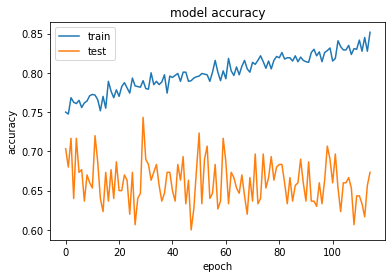

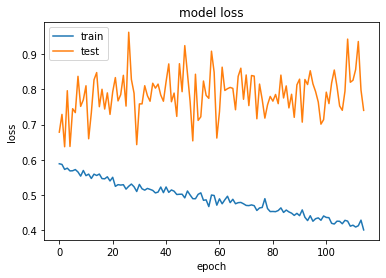

In [ ]:
# Eventuellement visualiser la courbe d'apprentissage 
historique = best_model.fit(x_train, y_train,batch_size=40,epochs=115,verbose=1,validation_data=(x_test, y_test), validation_split=0.2)

# History labels
print(historique.history.keys())

# Courbe : Accuracy
plt.plot(historique.history['accuracy'])
plt.plot(historique.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Courbe : Perte
plt.plot(historique.history['loss'])
plt.plot(historique.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Table de prédictions (donc sur le corpus de test)

predictionX = best_model.predict(x_test)

# Dataframe des probabilités
predX_test_df = pandas.DataFrame(predictionX)

# Y_TEST => Réponse sur 1 SEULE COLONNE 
maxima = numpy.argmax(y_test, axis=1)  
reponses = maxima.reshape(375,1)      # 375 car 125 audios par langue sachant qu'on a 3 langues
# print(reponses)

# PredictionX => Nb à la plus forte probabilité sur 1 SEULE COLONNE 
maxPredX = numpy.argmax(predictionX, axis=1) 
predX = maxPredX.reshape(375,1)
# print(predX)

# Concaténation de la dataframe des x_test, des réponses données par y_test et des prédictions (meilleurs scores dans x_test)
Y = pandas.DataFrame(reponses, columns=["Réponses"])
X = pandas.DataFrame(predX, columns=["Prédictions"])
pandas.concat([predX_test_df, Y, X], axis=1)

,0,1,2,Réponses,Prédictions
0,0.483978,0.481078,0.591459,0,2
1,0.938288,0.646605,0.025071,0,0
2,0.999952,0.973232,0.000002,0,0
3,0.438052,0.790605,0.248857,0,1
4,0.711850,0.318649,0.399486,0,0
...,...,...,...,...,...
370,0.347892,0.441048,0.739320,2,2
371,0.697258,0.613309,0.216002,2,0
372,0.245324,0.780781,0.607942,2,1
373,0.752266,0.747036,0.116508,2,0


ESSAI MODELE 2

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils.data_utils import Sequence
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
# Répertoire du corpus d'entraînement
train_path = '/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_R/train/'
# Répertoire du corpus de test
test_path = '/content/drive/MyDrive/Projet_CNN/corpus_spectrogrammes/corpus_R/test/'

In [ ]:
# Générateur de données : permet de charger les données sous forme de flux
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



train_batches = train_datagen.flow_from_directory(
        # Répertoire cible
        train_path,
        # Agrandissement des images (est-ce que c'est la peine ? sinon on les laisse à 28x28)
        target_size=(50, 50),
        # Taille du batch : 10
        batch_size=10,
        # Résultats classés en catégories
        class_mode='categorical')


test_batches = test_datagen.flow_from_directory(
        # Répertoire cible
        test_path,
        # Agrandissement des images (est-ce que c'est la peine ? sinon on les laisse à 28x28)
        target_size=(50, 50),
        # Taille du batch : 10
        batch_size=10,
        # Résultats classés en catégories
        class_mode='categorical')

Found 1500 images belonging to 3 classes.
Found 375 images belonging to 3 classes.


In [ ]:
imgs, labels = next(train_batches)

In [ ]:
# Chargement du modèle et de ses différentes couches
# conv2D : couche de convolution 
# Maxpool2D : couche de pooling, permet de créer une version condensée de l'information
# Flatten : Applatit les données d'entrées
# Dense : permet de connecter tous les neurones à ceux de la couche précédente
# Dropout : permet de réduire l'overfitting du modèle
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(units=3, activation='softmax')
])

In [ ]:
# permet de définir comment réaliser une propagation en arrière
# 3 arguments sont utilisés : un optimiseur, une fonction d’erreur et une liste de métriques.
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])


In [ ]:
# Nombre de fois que les données vont passer à travers les couches du modèle
epochs = 40
# Entraînement du modèle
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    epochs=40,
    verbose=1,
    validation_data=test_batches
)

Epoch 1/40
150/150 [==============================] - 453s 3s/step - loss: 1.0976 - accuracy: 0.3567 - val_loss: 1.0975 - val_accuracy: 0.3360
Epoch 2/40
150/150 [==============================] - 6s 40ms/step - loss: 1.0975 - accuracy: 0.3520 - val_loss: 1.0968 - val_accuracy: 0.3333
Epoch 3/40
150/150 [==============================] - 6s 39ms/step - loss: 1.0952 - accuracy: 0.3673 - val_loss: 1.0937 - val_accuracy: 0.4027
Epoch 4/40
150/150 [==============================] - 6s 39ms/step - loss: 1.0935 - accuracy: 0.3880 - val_loss: 1.0903 - val_accuracy: 0.3813
Epoch 5/40
150/150 [==============================] - 6s 39ms/step - loss: 1.0893 - accuracy: 0.3927 - val_loss: 1.0897 - val_accuracy: 0.3413
Epoch 6/40
150/150 [==============================] - 6s 40ms/step - loss: 1.0827 - accuracy: 0.4080 - val_loss: 1.0800 - val_accuracy: 0.4187
Epoch 7/40
150/150 [==============================] - 6s 39ms/step - loss: 1.0748 - accuracy: 0.4107 - val_loss: 1.0788 - val_accuracy: 0.3813

In [ ]:
test_imgs, test_labels = next(test_batches)

In [ ]:
# Prédiction du modèle
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

38/38 [==============================] - 1s 37ms/step - loss: 1.6793 - accuracy: 0.5867
[1.6793198585510254, 0.5866666436195374]
Epoch 1/40
150/150 [==============================] - 7s 44ms/step - loss: 0.1212 - accuracy: 0.9527 - val_loss: 1.9185 - val_accuracy: 0.5787
Epoch 2/40
150/150 [==============================] - 6s 40ms/step - loss: 0.1254 - accuracy: 0.9493 - val_loss: 1.7752 - val_accuracy: 0.5973
Epoch 3/40
150/150 [==============================] - 6s 39ms/step - loss: 0.1023 - accuracy: 0.9607 - val_loss: 1.7754 - val_accuracy: 0.6160
Epoch 4/40
150/150 [==============================] - 6s 38ms/step - loss: 0.0535 - accuracy: 0.9820 - val_loss: 2.1933 - val_accuracy: 0.5813
Epoch 5/40
150/150 [==============================] - 6s 37ms/step - loss: 0.1043 - accuracy: 0.9553 - val_loss: 3.1293 - val_accuracy: 0.5120
Epoch 6/40
150/150 [==============================] - 6s 37ms/step - loss: 0.1719 - accuracy: 0.9453 - val_loss: 1.7471 - val_accuracy: 0.6000
Epoch 7/40
15

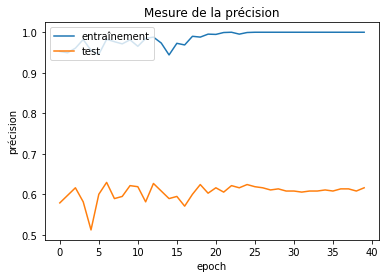

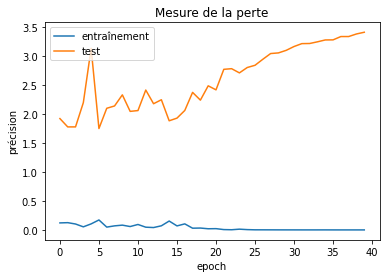

In [ ]:
# Evaluation du meilleur modèle grâce aux données de test
print(model.evaluate(x=test_batches))


historique = model.fit(train_batches,batch_size=10,epochs=40,verbose=1,validation_data=test_batches)

# History labels
print(historique.history.keys())

# Visualibation de la courbe d'apprentissage 

# Courbe : Accuracy
plt.plot(historique.history['accuracy'])
plt.plot(historique.history['val_accuracy'])
plt.title('Mesure de la précision')
plt.ylabel('précision')
plt.xlabel('epoch')
plt.legend(['entraînement', 'test'], loc='upper left')
plt.show()

# Courbe : Perte
plt.plot(historique.history['loss'])
plt.plot(historique.history['val_loss'])
plt.title('Mesure de la perte')
plt.ylabel('précision')
plt.xlabel('epoch')
plt.legend(['entraînement', 'test'], loc='upper left')
plt.show()

In [ ]:
# On arrondit les prédictions pour pouvoir créer une matrice de confusion
np.round(predictions)

array([[1., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_batches.class_indices

{'anglais': 0, 'espagnol': 1, 'francais': 2}

Confusion matrix, without normalization
[[45 50 30]
 [49 48 28]
 [51 48 26]]


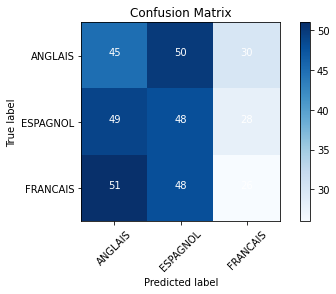

In [ ]:
cm_plot_labels = ['ANGLAIS','ESPAGNOL', 'FRANCAIS']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')